# Multi-class Segmentation과 U-Net 구현하기

## Prep

### 라이브러리

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import models
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 데이터 확인

In [2]:
image_list = glob('/kaggle/input/car-segmentation/car-segmentation/images/*')

mask_list = glob('/kaggle/input/car-segmentation/car-segmentation/masks/*')
len(image_list), len(mask_list)

(0, 0)

IndexError: list index out of range

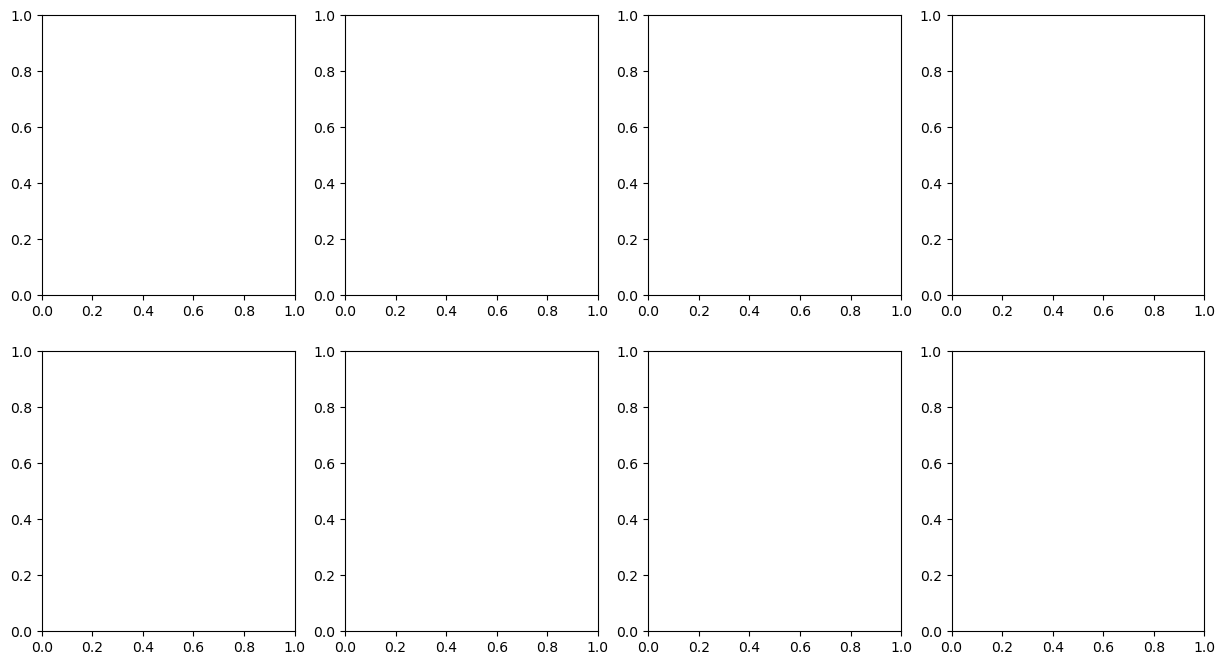

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(4):
    img_path = image_list[i]
    mask_path = image_list[i].replace('images', 'masks')
    
    axes[2 * i].imshow(Image.open(img_path))
    axes[2 * i].set_title(f'Image {i+1}')
    axes[2 * i].axis('off')
    
    axes[2 * i + 1].imshow(Image.open(mask_path))
    axes[2 * i + 1].set_title(f'Mask {i+1}')
    axes[2 * i + 1].axis('off')

### 클래스 확인

In [ ]:
with open('/kaggle/input/car-segmentation/car-segmentation/classes.txt', 'r') as f:
    cls_list = f.read().split(',')
    cls_list = [cls.strip() for cls in cls_list]
print(cls_list)
num_classes = len(cls_list)

### 마스크 고유값 확인

In [ ]:
unique, counts = np.unique(mask_list, return_counts=True)
for mask_path in mask_list:
    mask = Image.open(mask_path)
    mask = np.array(mask)
    print(mask)
#     print(mask.shape)
    print(np.unique(mask))
    break

### 이미지-마스크 겹쳐 그리기
`torchvision.utils.draw_segmentation_masks`

In [6]:
def imgs_with_masks(img_dir, start):
    img_dir = img_dir[start: start + 4]
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    
    for i, img_path in enumerate(img_dir):
        # 이미지 및 마스크 불러오기
        img = torchvision.io.read_image(img_path)
        mask = torchvision.io.read_image(img_path.replace('images', 'masks')).squeeze(0)  # 마스크에서 불필요한 채널 제거

        # 마스크를 원-핫 인코딩하여 5개의 클래스로 변환
        one_hot_mask = F.one_hot(mask.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
        print(img.shape, mask.shape, one_hot_mask.shape)
        
        # 각 마스크 채널을 True/False로 변환하여 오버레이 생성
        overlayed = torchvision.utils.draw_segmentation_masks(img, 
                                                              one_hot_mask.to(torch.bool), 
                                                              alpha=0.5, 
                                                              colors=['black', 'green', 'blue', 'yellow', 'purple'])

        axes[i].imshow(overlayed.permute(1, 2, 0))
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')

In [ ]:
imgs_with_masks(image_list, 0)

### 3차원이 아닌 이미지 제거

In [ ]:
exclude = []

for img_path in image_list:
    img = Image.open(img_path)
    img = np.array(img)
    if img.ndim != 3:
        print(img.shape)
        print(img.ndim)
        print(img_path)
        exclude.append(img_path)

In [9]:
for ex in exclude:
    image_list.remove(ex)
    mask_list.remove(ex.replace('images', 'masks'))

### Dataset
- Image: (B, 3, H, W)
- Mask: (B, H, W)

In [10]:
class CarDataset(Dataset):
    def __init__(self, image_list, mask_list, transform_img, transform_mask, num_classes=num_classes):
        
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.num_classes = num_classes
        
    def __len__(self):
        
        return len(self.image_list)
    
    def __getitem__(self, idx):
        
        image_path = self.image_list[idx]
        mask_path = image_path.replace('images', 'masks')
        
        image = Image.open(image_path)
        mask = torchvision.io.read_image(mask_path)
        
        
        # 이미지 Channel=4 -> RGBA
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        
        image = self.transform_img(image)
        mask = self.transform_mask(mask).squeeze(0).to(torch.long)
        
        return image, mask

In [11]:
transform_img = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((224, 224)), 
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])

transform_mask = transforms.Compose([transforms.Resize((224, 224)),
                                    ])

In [ ]:
car_dataset = CarDataset(image_list, mask_list, transform_img, transform_mask)
print(car_dataset.__len__())

train_size = int(0.8 * len(car_dataset))
val_size = len(car_dataset) - train_size

train_ds, val_ds = random_split(car_dataset, [train_size, val_size])
print(f"Train dataset size: {len(train_ds)} | Validation dataset size: {len(val_ds)}")

train_dl = DataLoader(train_ds, batch_size = 16, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 16, shuffle = False)

imgs, masks = next(iter(train_dl))
print(imgs.shape, masks.shape)

## 학습 및 추론

### 모델

In [96]:
class FCN8s(nn.Module):
    def __init__(self, n_classes):
        super(FCN8s, self).__init__()
        vgg = models.vgg16(pretrained=True)
        features = list(vgg.features.children())

        # VGG16의 각 블록을 PyTorch Sequential로 구성
        self.block3 = nn.Sequential(*features[:17])  # Conv1 ~ Conv3
        self.block4 = nn.Sequential(*features[17:24])  # Conv4
        self.block5 = nn.Sequential(*features[24:])  # Conv5

        # 추가 Conv 레이어
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7, padding=3)
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)

        # FCN에서 사용할 1x1 Conv
        self.conv1x1_pool3 = nn.Conv2d(256, n_classes, kernel_size=1)
        self.conv1x1_pool4 = nn.Conv2d(512, n_classes, kernel_size=1)
        self.conv1x1_output = nn.Conv2d(4096, n_classes, kernel_size=1)

        # Transposed convolutions for upsampling
        self.upconv2 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, padding=1)
        self.upconv8 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=8, stride=8, padding=0)

    def forward(self, x):
        # VGG16 인코더 부분
        p3 = self.block3(x)  # (256, H/8, W/8)
        p4 = self.block4(p3)  # (512, H/16, W/16)
        p5 = self.block5(p4)  # (512, H/32, W/32)
        p5 = F.relu(self.conv6(p5))  # (4096, H/32, W/32)
        p5 = F.relu(self.conv7(p5))  # (4096, H/32, W/32)

        # FCN-8 헤드 부분
        score = self.conv1x1_output(p5)
        score = self.upconv2(score) + self.conv1x1_pool4(p4)
        score = self.upconv2(score) + self.conv1x1_pool3(p3)
        output = self.upconv8(score)

        return output

In [ ]:
# 모델 인스턴스 생성
model = FCN8s(n_classes=num_classes).to(device)

input_image = torch.randn(1, 3, 224, 224).to(device)

output = model(input_image)
print(output.shape)

### 학습 루프 설정

In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 5e-4)
epochs = 15

In [ ]:
dummy_gt = torch.randint(0, 5, (1, 224, 224))
dummy_pred = torch.rand(1, 5, 224, 224)

### 평가지표
- mean IoU
- mean Pixel Accuracy  
두 지표를 다중 클래스 세그멘테이션 모델에 적용하도록 바꿔봅니다.

In [40]:
def IoU(output, mask, num_classes):
	output = torch.argmax(output, dim=1)  # 각 픽셀에서 가장 높은 값(클래스) 선택
    iou_per_class = []

	for cls in range(num_classes):
		pred_class = (output==cls)
		true_class = (mask==cls).float()

		intersection = torch.sum(output * mask)
    	union = torch.sum(output) + torch.sum(mask) - intersection
		iou = (intersection + 1e-7) / (union + 1e-7)

		iou_per_class.append(iou)

	return torch.mean(torch.stack(iou_per_class))

    """
	output(pred): (B, C, H, W), C = num_classes
	mask(gt): (B, H, W)
	두 tensor 간 비교를 위하여 output map의 채널을 축소시켜야 함.

    1. 각 클래스별로 IoU 계산
    2. 클래스별 IoU를 평균하여 최종 IoU 반환
    """
    output = torch.argmax(output, dim=1)  # 각 픽셀에서 가장 높은 값(클래스) 선택
    iou_per_class = []

	split_outputs = torch.split(output, dim=1)

	for i in range(len(split_outputs[i])):
		split_output = split_outputs[i]
		intersection = torch.sum(split_outputs * mask)
		union = torch.sum(split_output) + torch.sum(mask) - intersection
		iou = intersection / union + 1e-7
		iou_per_class.append(iou)

    return mean(iou_per_class)

def PA(output, mask):
    """
    1. 각 픽셀의 클래스 예측과 실제 클래스의 일치 여부 계산
    2. 전체 픽셀 중 일치하는 픽셀의 비율 반환
    """
    output = torch.argmax(output, dim=1)  # 각 픽셀에서 가장 높은 값(클래스) 선택
    correct = torch.sum(output==mask)
	total = torch.numel()
	overall_acc

	for cls in range(num_classes):
		class_mask = (mask==cls).float()
		class_output = (output == cls).float()

		class_correct = torch.sum(class_output & class_mask)
		class_total = torch.sum(class_mask)
		class_accuracy = (class_correct) / (class_total)
		class_accuracies.append(class_accuracy)
    return 

TabError: inconsistent use of tabs and spaces in indentation (777576917.py, line 13)

### 학습 루프

In [18]:
def train_and_validate(model, train_loader, val_loader, optim, criterion, epochs, num_classes):
    train_losses = []
    train_IoUs = []
    train_PAs = []
    val_losses = []
    val_IoUs = []
    val_PAs = []
    
    for epoch in range(epochs):
        train_loss = 0
        train_IoU = 0
        train_PA = 0
        model.train()
        for img, mask in tqdm(train_loader):
            img = img.to(device)
            mask = mask.to(device)
            optim.zero_grad()
            output = model(img)
            loss = criterion(output, mask)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            train_IoU += IoU(output.detach().cpu(), mask.detach().cpu(), num_classes).item()
            train_PA += PA(output.detach().cpu(), mask.detach().cpu()).item()
            
        print(f"Epoch {epoch + 1}\nTrain loss: {train_loss / len(train_loader):.2f} | Train IoU: {train_IoU / len(train_loader):.2f} | Train Pixel Acc: {train_PA / len(train_loader):.2f}")
        train_losses.append(train_loss / len(train_loader))
        train_IoUs.append(train_IoU / len(train_loader))
        train_PAs.append(train_PA / len(train_loader))
        
        val_loss = 0
        val_IoU = 0
        val_PA = 0
        model.eval()
        with torch.no_grad():
            for img, mask in tqdm(val_loader):
                img = img.to(device)
                mask = mask.to(device)
                output = model(img)
                loss = criterion(output, mask)
                val_loss += loss.item()
                val_IoU += IoU(output.detach().cpu(), mask.detach().cpu(), num_classes).item()
                val_PA += PA(output.detach().cpu(), mask.detach().cpu()).item()
                
            print(f"Validation loss: {val_loss / len(val_loader):.2f} | Validation IoU: {val_IoU / len(val_loader):.2f} | Validation Pixel Acc: {val_PA / len(val_loader):.2f}\n{'='*100}")
            val_losses.append(val_loss / len(val_loader))
            val_IoUs.append(val_IoU / len(val_loader))
            val_PAs.append(val_PA / len(val_loader))
            
    return train_losses, train_IoUs, train_PAs, val_losses, val_IoUs, val_PAs


### 학습

In [ ]:
train_losses, train_IoUs, train_PAs, val_losses, val_IoUs, val_PAs = train_and_validate(model, train_dl, val_dl, optim, criterion, epochs, num_classes)

### 로그 시각화

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend()
plt.show()
plt.plot(train_IoUs, label = 'train mIoU')
plt.plot(val_IoUs, label = 'val mIoU')
plt.legend()
plt.show()
plt.plot(train_PAs, label = 'train Pixel Accuracy')
plt.plot(val_PAs, label = 'val Pixel Accuracy')
plt.legend()
plt.show()

In [19]:
def plot_batch(model, data_loader):
    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(data_loader):
            img = img.to(device)
            output = model(img)
            
            # output에서 가장 높은 클래스 인덱스 선택 (배치에서 각 픽셀별로 argmax)
            output = torch.argmax(output, dim=1).cpu().numpy()  # (batch_size, H, W)
            
            img = img.cpu().numpy().transpose(0, 2, 3, 1)  # (batch_size, H, W, 3)
            mask = mask.cpu().numpy()  # (batch_size, H, W)
            break
    
    for i in range(data_loader.batch_size):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        # 원본 이미지 시각화
        ax[0].imshow(img[i])
        ax[0].set_title('image')
        
        # 마스크 시각화 (vmin=0, vmax=5로 클래스 범위를 설정)
        ax[1].imshow(mask[i], cmap='gray', vmin=0, vmax=5)
        ax[1].set_title('mask')
        
        # 예측 마스크 시각화 (vmin=0, vmax=5로 클래스 범위를 설정)
        ax[2].imshow(output[i], cmap='gray', vmin=0, vmax=5)
        ax[2].set_title('predicted mask')
        
        plt.show()

In [ ]:
plot_batch(model, val_dl)

## U-net 구현
아래 그림과 설명을 따라 custom U-Net을 구현합니다.
![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*0qJdnSxkerwZPCWVdLPpHw.png)

- UNet은 **Encoder (Contracting Path)**와 **Decoder (Expansive Path)**로 나뉨
    - 4번의 Downsampling과 4번의 Upsampling
    - Upsampling은 convolutional transpose(kernel_size=2)
    - Downsampling는 max pooling(kernel_size=2)
- Feature map 크기가 유지되는 부분은 3*3 Conv 활용
    - 2번의 Conv layer와 2번의 ReLU
- Skip connection 시에는 Feature map을 합연산 하지않고 concat(`torch.cat(dim=1)`) 사용
- Decoder의 마지막 부분인 mask prediction에서 1x1 Conv 사용

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
	def __init__(self):
		super(UNet, self).__init__()
		# Mask : (B, 224, 224)
		# Image : (B, 3, 224, 224) -> (B, 5, 224, 224)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.relu = nn.ReLU()
		self.conv_output = nn.Conv2d(64, 5, kernel_size=1)
		self.enc_last = self.make_conv_set(512, 1024)	

	
	def make_conv_set(self, in_, out_):
		conv_set = nn.Sequential(nn.Conv2d(in_, out_, kernel_size=3, stride=1, padding=1),
									nn.ReLU(inplace=True),
									nn.Conv2d(out_, out_, kernel_size=3, stride=1, padding=1),
									nn.ReLU(inplace=True))
		return conv_set

	def encoder(self, img=None, in_=None, out_=None):
		conv_set = self.make_conv_set(in_, out_)
		sub = conv_set(img)
		x = self.pool(sub)
		
		return x, sub
	
	def decoder(self, img=None, sub=None, in_=None, out_=None):
		upconv = nn.ConvTranspose2d(in_, out_, kernel_size=2, stride=2)
		x = upconv(img)
		x = torch.cat((sub, x), dim=1)
		conv_set = self.make_conv_set(in_, out_)
		x = conv_set(x)

		return x

	def forward(self, x):
		x, sub1 = self.encoder(x, 3, 64)
		x, sub2 = self.encoder(x, 64, 128)
		x, sub3 = self.encoder(x, 128, 256)
		x, sub4 = self.encoder(x, 256, 512)
		x = self.enc_last(x)

		x = self.decoder(x, sub4, 1024, 512)
		x = self.decoder(x, sub3, 512, 256)
		x = self.decoder(x, sub2, 256, 128)
		x = self.decoder(x, sub1, 128, 64)
		x = self.relu(self.conv_output(x))

		return x

In [34]:
model = UNet()
input_image = torch.randn(1, 3, 224, 224)  # 배치 크기 1, 채널 3, 224x224 이미지
output = model(input_image)
print(output.shape)

torch.Size([1, 64, 112, 112]) torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 56, 56]) torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 28, 28]) torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 14, 14]) torch.Size([1, 512, 28, 28])
torch.Size([1, 5, 224, 224])


In [11]:
!pip install torchsummary

In [14]:
import torchsummary

torchsummary.summary(model, (3, 224,224))

forward
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1         [-1, 64, 112, 112]               0
         MaxPool2d-2          [-1, 128, 56, 56]               0
         MaxPool2d-3          [-1, 256, 28, 28]               0
         MaxPool2d-4          [-1, 512, 14, 14]               0
            Conv2d-5         [-1, 1024, 14, 14]       4,719,616
              ReLU-6         [-1, 1024, 14, 14]               0
            Conv2d-7         [-1, 1024, 14, 14]       9,438,208
              ReLU-8         [-1, 1024, 14, 14]               0
            Conv2d-9          [-1, 5, 224, 224]             325
             ReLU-10          [-1, 5, 224, 224]               0
Total params: 14,158,149
Trainable params: 14,158,149
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 21.44
Params size (MB): 5

In [4]:
import torch.nn as nn

In [17]:
encoder = nn.Sequential()
size = [224, 64, 128, 256, 512]

for i in range(len(size)-1):
	encoder.add_module(f'conv{i+1}_1', nn.ReLU(nn.Conv2d(size[i], size[i+1], kernel_size=1, stride=1, padding=1)))
	# encoder.add_module(f'reul{i+1}', nn.ReLU())
	encoder.add_module(f'conv{i+1}_2', nn.ReLU(nn.Conv2d(size[i+1], size[i+1], kernel_size=1, stride=1, padding=1)))
	encoder.add_module(f'maxpool{i+1}', nn.MaxPool2d(kernel_size=2, stride=2))

In [18]:
encoder

Sequential(
  (conv1_1): ReLU(
    inplace=True
    (inplace): Conv2d(224, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (conv1_2): ReLU(
    inplace=True
    (inplace): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): ReLU(
    inplace=True
    (inplace): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (conv2_2): ReLU(
    inplace=True
    (inplace): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): ReLU(
    inplace=True
    (inplace): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (conv3_2): ReLU(
    inplace=True
    (inplace): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [ ]:
model = UNet(in_channels=3, out_channels=num_classes).to(device)
dummy = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy)
output.shape

In [32]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 5e-4)
epochs = 15

In [ ]:
train_losses, train_IoUs, train_PAs, val_losses, val_IoUs, val_PAs = train_and_validate(model, train_dl, val_dl, optim, criterion, epochs, num_classes)

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend()
plt.show()
plt.plot(train_IoUs, label = 'train mIoU')
plt.plot(val_IoUs, label = 'val mIoU')
plt.legend()
plt.show()
plt.plot(train_PAs, label = 'train Pixel Accuracy')
plt.plot(val_PAs, label = 'val Pixel Accuracy')
plt.legend()
plt.show()

In [ ]:
plot_batch(model, val_dl)